# HW 5 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In Weeks 8 and 9 you discussed key concepts related to graph based algorithms and implemented SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__ 

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [5]:
spark

In [6]:
sc = spark.sparkContext

__`REMINDER`__: If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Do not respond in terms of any specific algorithm. Think in terms of the nature of the graph datastructure itself).*

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ One example would be: the dataset of likes on social network - each user account would be nodes, if person A likes a posting by person B, then there would be an edge connecting them. This is directed graph. The  average "in-degree" of a node means the average number of likes received by each user account. 

> __b)__ Graphs data are a network of connections among nodes, which means, they are relatively more dependent on neighbors than tabular data. It is challenging to decompose the network of data into subsets for map-reduce paradigm to work. 

> __c)__ The Dijskra'a algorithm is an algorithm to solve single-source shortest path problem, where the task is to find shortest paths from a source node to all other nodes in the graph. The approach of this algorithm can be summarized as the following steps:
- Set distances to all vertices (distance values d) to $\infty$, and the distance to the source node itself to zero. 
- Initiate a global priority queue (Q) with priorities equal to their distance values d; which means, source node has the lowest distance;
- Iteratively select the node with the lowest current distance from the priority queue. Therefore, at iteration one, source node would be selected. 
- At each iteration, the algorithm loops through the neighbors of the currently selected node to see which neighbor can be reached with a shorter distance. 
- Terminates when the priority queue Q is empty. 

> Because it assumes sequential processing, it is thus hard to parallelize. Another big hurdle is that the algorithm requires to maintain a priority queue Q which is a globally sorted list based off current distance. 

> __d)__ Instead of keeping a globablly sorted queue, the parallel breadth-first-search algorithm gets around the problems by the following approaches: 
- first put source node in the frontier list;
- Each MapReduce iteration, the mappers expand all nodes in the frontier in parallel, to emit a key-value pair for each neighbor on the node’s adjacency list; the reducers will select the shortest of these distances and then update the distance in the node data structure.
- The key is that at the end of each MapReduce iteration, the node data structure is passed to the next iteration. 

> The expense would be: this algorithm spends a lot of time performing interim computations because at each iteration, the distance is calculated and the shortest selected. These interim results will be discarded in the end. In this sense, this algorithm is less efficient than Dijskra'a algorithm. 
 

> __References__
- Jimmy Lin and Chris Dyer, *Data-Intensive Text Processing with MapReduce*, April 11, 2010

# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="Lin-Dyer-graph-Q1.png" width="70%">

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.


### Q2 Student Answers:
> __a)__ I think the adjacency matrix in Figure 5.1 is "sparse" because we see more zeros than ones (8 out of 25); whereas adjacency list is relatively denser than adjacency matrix. The sparsity of adjacency matrix requires more space to store all the cell data.  

> __b)__ The graph is directed. For undirected graphs, only half of the matrix is used; whereas for directed graphs, all cells in the matrix will be used. 

In [7]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

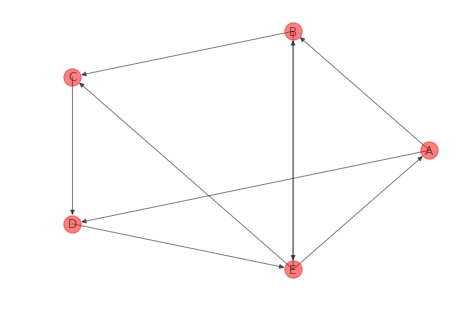

In [8]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5)

In [9]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
    for pair in graph['edges']:
        adj_matr[pair[1]][pair[0]] = 1
    ############### (END) YOUR CODE #################
    return adj_matr

In [10]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

   A  B  C  D  E
A  0  1  0  1  0
B  0  0  1  0  1
C  0  0  0  1  0
D  0  0  0  0  1
E  1  1  1  0  0


In [11]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for pair in graph['edges']:
        adj_list[pair[0]].append(pair[1])
    
    ############### (END) YOUR CODE #################
    return adj_list

In [12]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}


# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

### Q3 Student Answers:
> __a)__ PageRank metric measures the probability in which a random walk over the web-graph will arrive at a particular node, the higher the in-degrees of a node, the higher its PageRank value would be. 

> __b)__ The "Markov property" refers to a memoryless characteristic where the conditional probability distribution for consequent future state only depends on the current state, and not depend on the sequence of events that preceded it. In the context of PageRank, each page can be considered as a state. We can view PageRank as a steady-state probability distribution of the Markov process underlying the random-surfer navigation model, which provides a mathematical approach to calculate each page's PageRank.

> __c)__ The $n$ states are referred to as the $n$ pages in the Webgraph. The larger $n$ is, the matrix with a size of $n \times n$ would get substantially large and sparse, which would be inefficient for large data computation.

> __d)__ A 'right stochastic matrix' is a square matrix of nonnegative real numbers, with each row summing to 1.

> __e)__ The method converges after about iteration 45, as the numbers stay stable afterwards. Node E is considered most 'central' with highest rank score. Yes, it matches with my intuition because Node E has two in-degrees and three out-degrees, whereas Node B/C/D all have two in-degrees and one out-degree, and Node A has only one in-degree and two out-degrees. 

> __References__
- Jimmy Lin and Chris Dyer, *Data-Intensive Text Processing with MapReduce*, April 11, 2010
- https://en.wikipedia.org/wiki/Markov_chain
- MIDS W261 async video - Unit 9, *Large-Scale Graph Processing: Random Walks, PageRank, and Personalized PageRank*. 

In [13]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [14]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
transition_matrix = TOY_ADJ_MATR.div(TOY_ADJ_MATR.sum(axis=1), axis=0).values # replace with your code

################ (END) YOUR CODE #################
print(transition_matrix)

[[0.         0.5        0.         0.5        0.        ]
 [0.         0.         0.5        0.         0.5       ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333 0.         0.        ]]


In [15]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    ################ YOUR CODE HERE #################
    state_vector = xInit
    for i in range(nIter):
        state_vector = np.dot(state_vector, tMatrix)
        if verbose:
            print("Step:", i+1)
            print("Current matrix:")
            print(state_vector)
            print("*"*60)
    
    ################ (END) YOUR CODE #################
    return state_vector

In [16]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)

Step: 1
Current matrix:
[0.  0.5 0.  0.5 0. ]
************************************************************
Step: 2
Current matrix:
[0.   0.   0.25 0.   0.75]
************************************************************
Step: 3
Current matrix:
[0.25 0.25 0.25 0.25 0.  ]
************************************************************
Step: 4
Current matrix:
[0.    0.125 0.125 0.375 0.375]
************************************************************
Step: 5
Current matrix:
[0.125  0.125  0.1875 0.125  0.4375]
************************************************************
Step: 6
Current matrix:
[0.14583333 0.20833333 0.20833333 0.25       0.1875    ]
************************************************************
Step: 7
Current matrix:
[0.0625     0.13541667 0.16666667 0.28125    0.35416667]
************************************************************
Step: 8
Current matrix:
[0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]
************************************************************
Step

In [17]:
### Experiment with nIter to find the stable state
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 55, verbose = True)

Step: 1
Current matrix:
[0.  0.5 0.  0.5 0. ]
************************************************************
Step: 2
Current matrix:
[0.   0.   0.25 0.   0.75]
************************************************************
Step: 3
Current matrix:
[0.25 0.25 0.25 0.25 0.  ]
************************************************************
Step: 4
Current matrix:
[0.    0.125 0.125 0.375 0.375]
************************************************************
Step: 5
Current matrix:
[0.125  0.125  0.1875 0.125  0.4375]
************************************************************
Step: 6
Current matrix:
[0.14583333 0.20833333 0.20833333 0.25       0.1875    ]
************************************************************
Step: 7
Current matrix:
[0.0625     0.13541667 0.16666667 0.28125    0.35416667]
************************************************************
Step: 8
Current matrix:
[0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]
************************************************************
Step

__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.


### Q4 Student Answers:
> __a)__ In the transition matrix, the row for node E does not add up to 1. Because node E does not navigate to any of the nodes, all probability is zero. In addition, the state vector does not sum up to one. Furthermore, it's noticed that the state vector values seem to bounce up and down rather than converging towards one direction. 

> __b)__ Node E is the dangling node, because it does not navigate to any of the nodes. If web surfer goes in here, he/she will be trapped here. We should add up a teleportation matrix to the transition matrix after each iteration to prevent this problem. $\text{Revised Transition Matrix} = (1 - \alpha) \cdot \text{Original Transition Matrix} + \alpha \cdot \text{Teleportation Matrix}$, where $\alpha$ is probability of random jump. 

> __c)__ 'Irreducible' means that there is a path from every node to every other node. I don't think a webgraph is naturally irreducible. When designing a website, not every web page will be designed with a link to navigate to other page(s), for example some links are just image files or pdf files which would not contain any link to other pages. 

> __d)__ 'Aperiodic' means that he period, or greatest common divisor (GCD), of all cycle lengths is 1; or equivalently, there is no a larger-than-one integer that can divide the length of every cycle of the graph. I think a webgraph is not naturally aperiodic. Because a lot of web pages only have one outgoing link, starting on these pages would affect the probability of landing on other pages, and may impact the convergence to steady state. 

> __e)__ Two adjustments need to be made:
- Stochasticity adjustment which allows us to get over dangling nodes. This is the $\text{Teleportation Matrix}$ in our formula above in __(b)__. 
- Primitivity adjustment is made to guarantee aperiodicity and irreducibility. It is arrived at through a teleportation factor, $\alpha$, see formular above in __(b)__. Uisng the random surfer analogy, it can be thought of as a random surfer that gets bored sometimes while following the hyperlink structure of the web, and, instead of following links at random, enters a new URL in the URL bar to jump to the new link. 

> __References__
- MIDS W261 async video - Unit 9, *Large-Scale Graph Processing: Random Walks, PageRank, and Personalized PageRank*. 
- https://en.wikipedia.org/wiki/Aperiodic_graph

In [18]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

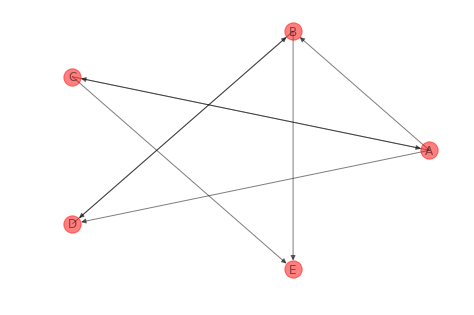

In [19]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5)

In [20]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
# 1. get adjacency matrix
TOY2_ADJ_MATR = get_adj_matr(TOY2_GRAPH)

# 2. get transition matrix, and replace nan with zero value
transition_matrix_2 = TOY2_ADJ_MATR.div(TOY2_ADJ_MATR.sum(axis=1), axis=0).values 
transition_matrix_2 = np.nan_to_num(transition_matrix_2)
print("Transition matrix for TOY2_GRAPH:")
print(transition_matrix_2, "\n")

# 3. run 10 steps of the power iteration method
xInit = np.array([1.0, 0, 0, 0, 0]) 
states = power_iteration(xInit, transition_matrix_2, 10, verbose = True)

################ (END) YOUR CODE #################

Transition matrix for TOY2_GRAPH:
[[0.         0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.         0.5        0.5       ]
 [0.5        0.         0.         0.         0.5       ]
 [0.         1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]] 

Step: 1
Current matrix:
[0.         0.33333333 0.33333333 0.33333333 0.        ]
************************************************************
Step: 2
Current matrix:
[0.16666667 0.33333333 0.         0.16666667 0.33333333]
************************************************************
Step: 3
Current matrix:
[0.         0.22222222 0.05555556 0.22222222 0.16666667]
************************************************************
Step: 4
Current matrix:
[0.02777778 0.22222222 0.         0.11111111 0.13888889]
************************************************************
Step: 5
Current matrix:
[0.         0.12037037 0.00925926 0.12037037 0.11111111]
************************

# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

__IMPORTANT NOTE:__ For Question 8, when working with the full dataset, you will need to submit a .py script to the cluster. Please follow the instructions provided and Office Hour recordings, if you need help with this. 

In [ ]:
# create a data directory (RUN THIS CELL AS IS)
!mkdir data

In [ ]:
# download the test data set (RUN THIS CELL AS IS)
!wget -q -O data/test_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AACf_33TeM7rKfEhjEoNmMCaa/PageRank-test_indexed.txt?dl=0

In [ ]:
# take a look (RUN THIS CELL AS IS)
!cat data/test_graph.txt

In [ ]:
# download the main data set - this may take a little time (RUN THIS CELL AS IS)
!wget -q -O data/wiki_graph.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAD7I_6kQlJtDpXZPhCfVH-a/wikipedia/all-pages-indexed-out.txt?dl=0

In [ ]:
# take a look (RUN THIS CELL AS IS)
!head data/wiki_graph.txt

In [ ]:
# download the indexes (RUN THIS CELL AS IS)
!wget -q -O data/indices.txt https://www.dropbox.com/sh/2c0k5adwz36lkcw/AADSYhyRXbgebRDy6ALl6O1ca/wikipedia/indices.txt?dl=0

In [ ]:
# take a look (RUN THIS CELL AS IS)
!head data/indices.txt

In [21]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile('data/test_graph.txt')
indexRDD = sc.textFile('data/indices.txt')
wikiRDD = sc.textFile('data/wiki_graph.txt')

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__ The raw data is in key-value pair format, where the value is in dictionary format. The first part of the value represents the source node; the second part of the line represents {destination node: the shortest distance from source node to destination node}. 

> __b)__ Some nodes are dangling nodes which does not go out to other node(s), in this case, they are not listed as a key (an individual record) in the raw data file. Therefore, the total records are less than the total number of nodes.   

> __d)__ There are $15192277-5781290 = 9410987$ dangling nodes in this wikipedia graph.   


In [22]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
!wc -l data/wiki_graph.txt

5781290 data/wiki_graph.txt


In [23]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    totalCount = dataRDD.map(lambda line: line.split('\t')) \
                        .map(lambda x: (ast.literal_eval(x[0]), ast.literal_eval(x[1]))) \
                        .flatMapValues(lambda x: set(x.keys())) \
                        .mapValues(lambda x: ast.literal_eval(x)) \
                        .flatMap(lambda x: set([x[0], x[1]])) \
                        .distinct() \
                        .count()

    
    ############## (END) YOUR CODE ###############   
    return totalCount

In [24]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 2.279386520385742 seconds.
Total Nodes: 11


In [25]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 1323.633445739746 seconds.
Total Nodes: 15192277


# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ We use each node's out degrees and the total number of nodes to calculate a transition matrix. For PageRank calculation, the formula can be written as following:
- $PR(x | W) = \alpha \frac{1}{|W|} + (1 - \alpha) \sum\limits_{i=1}^{n} \frac{PR(t_i)}{C(t_i)}$
- where $x$ is a node, $|W|$ is the total number of nodes in the graph, $C(t)$ is the out-degree of $t$, and $\alpha$ is probability of random jump. 

> __c)__ It means that the node is a dangling node. In the case of dangling nodes, we ignore dangling nodes in the calculation, but in order for our calculation to converge, we apply $\alpha$ which is probability of random jump, as well as Teleportation Matrix. 

> __References__
- MIDS W261 async video - Unit 9, *Large-Scale Graph Processing: Random Walks, PageRank, and Personalized PageRank*.

In [26]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############
    # 1. Set up base RDD for calculation:
    #    - rankRDD: (node, sum of out-degree)
    #    - rank_valueRDD: RDD with just the sum of out-degree for each node. 
    rankRDD = dataRDD.map(parse) \
                     .map(lambda x: (x[0], sum(x[1].values()))) \
                     .cache()
    rank_valueRDD = rankRDD.values().cache()
    
    # 2. Get the top 10 nodes with most edges
    top = rankRDD.takeOrdered(10, key=lambda x: -x[1])
    
    # 3. Get the average degree
    totalCount = rankRDD.count()
    totalSum = rank_valueRDD.sum()
    avgDegree = totalSum / totalCount
    
    # 4. Get a list of integer by sampling rank_valueRDD
    sampledCounts = rank_valueRDD.takeSample(False, n, 2019)
    
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

... completed job in 0.743431568145752 seconds
Average out-degree:  2.2
Top 10 nodes (by out-degree:)
 [('5', 5), ('6', 3), ('3', 2), ('4', 2), ('7', 2), ('8', 2), ('9', 2), ('11', 2), ('2', 1), ('10', 1)]


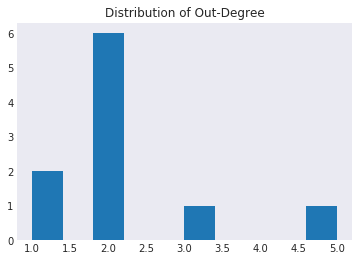

In [27]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
plt.show()

... completed job in 349.46259593963623 seconds
Average out-degree:  32.04181575392343
Top 10 nodes (by out-degree:)
 [('7804599', 9347), ('7858931', 8910), ('11185362', 8837), ('7705822', 8142), ('5760310', 7649), ('7865920', 7608), ('7819767', 7278), ('7883280', 7231), ('13035895', 7126), ('7880980', 6904)]


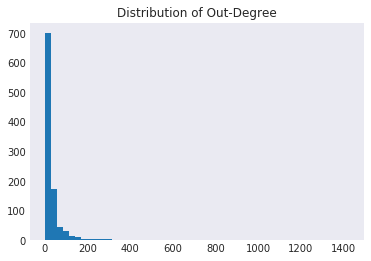

In [28]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
plt.show()

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code $N$.

### Q7 Tasks:
* __a) short response:__ What is $N$? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to $\frac{1}{N}$. (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute $N$ before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__ $N$ is the number of total nodes. In the analogy of infinite random web-surfing, we initializing each node's rank to  $\frac{1}{N}$ by assuming each node has the same probability of being hit. If we have $N$ total nodes, each node would have a probability of $\frac{1}{N}$. 

> __b)__ I think it would be more efficient to compute $N$ after initializing records for each dangling node. Because if we compute $N$ beforehands, we would need to go through the entire dataset first to get the total count, and then go through the dataset one more time to initialize records for dangling nodes. But if we do it afterwards, we just need to go through the dataset once to initialize dangling nodes without any score, cache the RDD, and then get the count of the cached RDD for $N$ to update their scores to $\frac{1}{N}$.  

In [29]:
# part c - job to initialize the graph (RUN THIS CELL AS IS) 
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############    
    # write any helper functions here
    def parse(line):
        """
        Parsing each line of record:
        - create (key,value) pair
        - convert value format to dict
        """
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    def getEdges(line):
        """
        For nodes that are the keys of RDD:
        - convert their format to a tuple of (node_id, edges)
        - This will only list out node that are existing RDD keys
        - If a node has duplicate edges, the function will emit duplicate items. 
        """
        edges = ''
        for key, value in line[1].items():
            edges += (key+',')*value
        return (line[0], edges[:-1])
    
    def convertEdgeToNode(line):
        """
        For nodes that are listed as edges of key nodes:
        - convert their format to a tuple of (node_id, [])
        """
        for node in line[1].split(','):
            yield (node, '')
    
    # write your main Spark code here
    # 1. Convert existing RDD to (node_id , list of edges)) format 
    keyRDD = dataRDD.map(parse) \
                    .map(getEdges) \
                    .cache()
    
    # 2. Create a new RDD with edges as keys
    edgeRDD = keyRDD.flatMap(convertEdgeToNode).cache()
    
    # 3. Merge both RDDs, then reduce by key
    init_graphRDD = keyRDD.union(edgeRDD) \
                          .reduceByKey(lambda x, y: (x + y)) \
                          .cache()
                        
    # 4. Compute N
    N = init_graphRDD.count()
    
    # 5. Update the init_graphRDD to include score as 1/N
    graphRDD = init_graphRDD.map(lambda x: (x[0], (1/N, x[1]))).cache()
    
    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [30]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 0.8916275501251221 seconds.


[('4', (0.09090909090909091, '1,2')),
 ('10', (0.09090909090909091, '5')),
 ('3', (0.09090909090909091, '2,2')),
 ('6', (0.09090909090909091, '2,5,5')),
 ('7', (0.09090909090909091, '2,5')),
 ('8', (0.09090909090909091, '2,5')),
 ('9', (0.09090909090909091, '2,5')),
 ('1', (0.09090909090909091, '')),
 ('2', (0.09090909090909091, '3')),
 ('5', (0.09090909090909091, '4,4,4,2,6')),
 ('11', (0.09090909090909091, '5,5'))]

In [31]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 1102.3704662322998 seconds


In [32]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 15192277
First record: [('21439', (6.582291778908455e-08, '21438'))]
... initialization continued: 83.34683465957642 seconds


# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='PR-illustrated.png'>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ $\alpha$ is the probability of random jump, we assume that there is no bias as to which page the web surfer would jump to, thus equal probability to each page, that is, $\frac{1}{|G|}$ if random jump occurs. Therefore, each page would have a probability of $\alpha \cdot \frac{1}{|G|}$ of being randomly jumped. 

> __b)__ $m$ is considered as 'dangling mass'. Because dangling node E (in above example) has no place to go under normal condition, but in the case of random jump and teleportation, we assume that it could jump to each node with equal probability, and thus we distribute its mass evenly to each node. 

> __c)__ Total mass should always be one after each iteration.  

In [33]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [34]:
### PART d - version 1 - use string as edges, and separate edges into another RDD

# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.
    def mapper(line):
        """
        a mapper function to distribute node's score to linked edges:
        - linked edges would get the credits;
        - self will not get credits
        - credit is calculated by original score / (total of linked edges), duplciate edges will be counted 
        """
        node, score, edges = [line[0]], line[1][0], line[1][1]
        if edges == '':
            edge_list = []
            credit = 0
        else:
            edge_list = edges.split(',')
            nlinks = len(edge_list)
            credit = score / nlinks
        
        node_list = node + edge_list
        for i in node_list:
            if i == line[0]:
                yield (i, 0)
            else:
                yield (i, credit)
    
    def getDM(line, mmAccumulator, totAccumulator):
        """A function to update missing mass accumulator, and return input line"""
        if line[1][1] == '':
            mmAccumulator.add(line[1][0]) 
        totAccumulator.add(line[1][0])
    
    def updateScore(line, mm, G, a, d):
        """
        A function to update score:
        - mm: missing mass (or dangling mass), calculated by the value of missing mass accumulator
        - G: total number of distinct nodes
        - a: alpha, (float) teleportation factor
        - d: (1-alpha)
        """
        node, score = line[0], line[1]
        new_score = a/G + d*(mm/G + score)
        return (node, new_score)
    
        
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    
    ## 1. Get the count of total distinct nodes
    G = graphInitRDD.count()
    # broadcast total nodes:
    G_bc = sc.broadcast(G)
    
    ## 2. Save edges of graph into a separate RDD
    edgeRDD = graphInitRDD.map(lambda x: (x[0], x[1][1])).cache()
    
    for i in range(maxIter):
        ## 3. Calculate the missing mass at the beginning of each iteration
        graphInitRDD.foreach(lambda x: getDM(x, mmAccum, totAccum))
        dangling_mass = sc.broadcast(mmAccum.value)
        total_mass = totAccum.value
        
        ## 4. Apply mapper function, reduce by key to combine credits from multiple sources, update score based off formula 
        graphInitRDD = graphInitRDD.flatMap(mapper) \
                                   .reduceByKey(lambda x, y: (x+y)) \
                                   .map(lambda x: updateScore(x, dangling_mass.value, G_bc.value, a.value, d.value)) \
                                   .rightOuterJoin(edgeRDD) \
                                   .cache()
        
        ## 5. If verbose=True, print out the missing mass and total mass for each iteration
        if verbose:
            print(f"Step {i}: missing mass = {dangling_mass.value}; total mass = {total_mass}")
        
        ## 6. Reset accumulators for dangling mass & total mass at the end of each iteration
        mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
        totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ## 7. Output the steady state RDD after looping ends
    steadyStateRDD = graphInitRDD.map(lambda x: (x[0], x[1][0])).cache()
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [ ]:
### PART d - version 2 - use string as edges DO NOT seperate edges into a different RDD. 
### This version works much faster for smaller dataset in container as compared to version 1. 
### However, version 1 works much faster for larger dataset in Google Cloud Platform. 

# part d - job to run PageRank (RUN THIS CELL AS IS)
# def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
#     """
#     Spark job to implement page rank
#     Args: 
#         graphInitRDD  - pair RDD of (node_id , (score, edges))
#         alpha         - (float) teleportation factor
#         maxIter       - (int) stopping criteria (number of iterations)
#         verbose       - (bool) option to print logging info after each iteration
#     Returns:
#         steadyStateRDD - pair RDD of (node_id, pageRank)
#     """
#     # teleportation:
#     a = sc.broadcast(alpha)
    
#     # damping factor:
#     d = sc.broadcast(1-a.value)
    
#     # initialize accumulators for dangling mass & total mass
#     mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
#     totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
#     ############## YOUR CODE HERE ###############
    
#     # write your helper functions here, 
#     # please document the purpose of each clearly 
#     # for reference, the master solution has 5 helper functions.
#     def mapper(line):
#         """
#         a mapper function to distribute node's score to linked edges:
#         - linked edges would get the credits;
#         - self will not get credits
#         - credit is calculated by original score / (total of linked edges), duplciate edges will be counted 
#         """
#         node, score, edges = [line[0]], line[1][0], line[1][1]
#         if edges == '':
#             edge_list = []
#             credit = 0
#         else:
#             edge_list = edges.split(',')
#             nlinks = len(edge_list)
#             credit = score / nlinks
            
#         node_list = node + edge_list
#         for i in node_list:
#             if i == line[0]:
#                 yield (i, (0, edges))
#             else:
#                 yield (i, (credit, ''))
    
#     def getDM(line, mmAccumulator, totAccumulator):
#         """A function to update missing and total mass accumulator"""
#         if line[1][1] == '':
#             mmAccumulator.add(line[1][0]) 
#         totAccumulator.add(line[1][0])
    
#     def updateScore(line, mm, G, a, d):
#         """
#         A function to update score:
#         - mm: missing mass (or dangling mass), calculated by the value of missing mass accumulator
#         - G: total number of distinct nodes
#         - a: alpha, (float) teleportation factor
#         - d: (1-alpha)
#         """
#         node, score, edges = line[0], line[1][0], line[1][1]
#         new_score = a/G + d*(mm/G + score)
#         return (node, (new_score, edges))
    
        
#     # write your main Spark Job here (including the for loop to iterate)
#     # for reference, the master solution is 21 lines including comments & whitespace
    
#     ## 1. Get the count of total distinct nodes
#     G = graphInitRDD.count()
#     # broadcast total nodes:
#     G_bc = sc.broadcast(G)
    
#     for i in range(maxIter):
#         ## 2. Calculate the missing & total mass at the beginning of each iteration
#         graphInitRDD.foreach(lambda x: getDM(x, mmAccum, totAccum))
#         dangling_mass = sc.broadcast(mmAccum.value)
#         total_mass = totAccum.value
        
#         ## 3. Apply mapper function, reduce by key to combine credits from multiple sources, update score based off formula 
#         graphInitRDD = graphInitRDD.flatMap(mapper) \
#                                    .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1])) \
#                                    .map(lambda x: updateScore(x, dangling_mass.value, G_bc.value, a.value, d.value)) \
#                                    .cache()
        
#         ## 4. If verbose=True, print out the missing mass and total mass for each iteration
#         if verbose:
#             print(f"Step {i}: missing mass = {dangling_mass.value}; total mass = {total_mass}")
        
#         ## 5. Reset accumulators for dangling mass & total mass at the end of each iteration
#         mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
#         totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
#     ## 6. Output the steady state RDD after looping ends
#     steadyStateRDD = graphInitRDD.map(lambda x: (x[0], x[1][0])).cache()
#     ############## (END) YOUR CODE ###############
    
#     return steadyStateRDD

In [35]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
### Use version 1 to run on test graph. We can see it's slow. If using version 2 for test graph, it is much faster. 
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: -x[1])

Step 0: missing mass = 0.09090909090909091; total mass = 1.0
Step 1: missing mass = 0.059297520661157024; total mass = 0.9999999999999999
Step 2: missing mass = 0.046703981968444774; total mass = 0.9999999999999999
Step 3: missing mass = 0.09925338433167132; total mass = 0.9999999999999999
Step 4: missing mass = 0.050342917879662344; total mass = 0.9999999999999999
Step 5: missing mass = 0.051459165449002614; total mass = 0.9999999999999999
Step 6: missing mass = 0.04500922379221685; total mass = 0.9999999999999998
Step 7: missing mass = 0.04715082459390296; total mass = 0.9999999999999998
Step 8: missing mass = 0.04374695430399097; total mass = 0.9999999999999998
Step 9: missing mass = 0.04376323453143378; total mass = 0.9999999999999998
Step 10: missing mass = 0.04298252973766269; total mass = 0.9999999999999998
Step 11: missing mass = 0.043012894839386674; total mass = 0.9999999999999996
Step 12: missing mass = 0.04272340069209819; total mass = 0.9999999999999999
Step 13: missing ma

[('2', 0.3620640495978871),
 ('3', 0.333992700474142),
 ('5', 0.08506399429624555),
 ('4', 0.06030963508473455),
 ('1', 0.04255740809817991),
 ('6', 0.03138662354831139),
 ('7', 0.01692511778009981),
 ('8', 0.01692511778009981),
 ('10', 0.01692511778009981),
 ('9', 0.01692511778009981),
 ('11', 0.01692511778009981)]

__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```

### Run PageRank on the full graph on GCP

**1. Results as shown in the screenshot below.** 

   <img src="GCP_fullresult_screenshot.png" width="600">
    
  
**2. Formatted full results are shown below.**

In [36]:
# 1. Copy the top 20 results from GCP Job log 
top_20 = [('13455888', 0.0015446797478818304), ('4695850', 0.0006710074985877836), 
          ('5051368', 0.0005983727917034681), ('1184351', 0.0005981982349229883), 
          ('2437837', 0.00046247355383209203), ('6076759', 0.00045507805784744947), 
          ('4196067', 0.00044231988558801854), ('13425865', 0.00044153410311422543), 
          ('6172466', 0.00042239167396062634), ('1384888', 0.0004012831313425879), 
          ('6113490', 0.0003957828681949651), ('14112583', 0.0003943680774185451), 
          ('7902219', 0.00037009170499711295), ('10390714', 0.0003650192247033904), 
          ('12836211', 0.00036198345487649565), ('6237129', 0.00035194723956766434), 
          ('6416278', 0.00034865439275406755), ('13432150', 0.0003393538540305369), 
          ('1516699', 0.00033296444523369544), ('7990491', 0.0003075544312595791)]

# 2. Convert the results into RDD
top_20_RDD = sc.parallelize(top_20)
top_20_RDD = top_20_RDD.map(lambda x: (int(x[0]), x[1]))
# top_20_RDD.take(1)

# 3. Change indexRDD: title\t indx\t inDeg\t outDeg to only include index and page title
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))
# namesKV_RDD.take(1)

In [37]:
# 4. Join namesKV_RDD with top_20_RDD to display page rank, page id, and page title
joinedWithNames = namesKV_RDD.join(top_20_RDD) \
                             .takeOrdered(20, key=lambda x: -x[1][1])

print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

PageRank  	| Page id   	| Title
0.001545	|   13455888	| United States
0.000671	|    4695850	| France
0.000598	|    5051368	| Germany
0.000598	|    1184351	| Animal
0.000462	|    2437837	| Canada
0.000455	|    6076759	| India
0.000442	|    4196067	| England
0.000442	|   13425865	| United Kingdom
0.000422	|    6172466	| Iran
0.000401	|    1384888	| Arthropod
0.000396	|    6113490	| Insect
0.000394	|   14112583	| World War II
0.000370	|    7902219	| List of sovereign states
0.000365	|   10390714	| Poland
0.000362	|   12836211	| The New York Times
0.000352	|    6237129	| Italy
0.000349	|    6416278	| Japan
0.000339	|   13432150	| United States Census Bureau
0.000333	|    1516699	| Australia
0.000308	|    7990491	| London


# Extra Credit
(The combined extra credit points amount to approximately 5 percentage points on your final grade.)

## EC 1 - Find David Bowie

<img src="labyrinth.jpg">

## EC 2 - 5pts
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and thier IDs.

* __a) code:__ Join this dataset with your top 20 results.
* __b) code:__ Print the results

Please see pretty print results above. 

## Join with indexRDD and print pretty

In [ ]:
# part a
joinedWithNames = None
############## YOUR CODE HERE ###############
joinedWithNames = namesKV_RDD.join(top_20_RDD) \
                             .takeOrdered(20, key=lambda x: -x[1][1]) \
############## END YOUR CODE ###############

In [ ]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

## GraphFrames --- IGNORED --- Replaced by A* 
## EC 2 - 30pts
GraphFrames is a graph library which is built on top of the Spark DataFrames API.

* __a) code:__ Using the same dataset, run the graphframes implementation of pagerank.
* __b) code:__ Join the top 20 results with indices.txt and display in the same format as above.
* __c) short answer:__ Compare your results with the results from graphframes.

__NOTE:__ Feel free to create as many code cells as you need. Code should be clear and concise - do not include your scratch work. Comment your code if it's not self annotating.

In [ ]:
from graphframes import *

In [ ]:
from pyspark.sql import functions as F

In [ ]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
testRDD = sc.textFile('gs://w261-bucket/wiki/test_graph.txt')
indexRDD = sc.textFile('gs://w261-bucket/wiki/indices.txt')
wikiRDD = sc.textFile('gs://w261-bucket/wiki/wiki_graph.txt')

In [ ]:
DF = wikiRDD.map(lambda x: (x.split('\t')[0], ast.literal_eval(x.split('\t')[1]))).toDF()

In [ ]:
%%time
DF.take(1)

In [ ]:
%%time
v = DF.select('_1').withColumnRenamed('_1','id').distinct()

In [ ]:
%%time
v.cache()

In [ ]:
%%time
v.show(1)

In [ ]:
import ast
def getEdges(row):
    node_id, nodes = row
    for node in nodes: 
        yield int(node_id), int(node)

In [ ]:
%%time
e = spark.createDataFrame(DF.rdd.flatMap(getEdges), ["src", "dst"])

In [ ]:
%%time
e.cache()

In [ ]:
%%time
e.show(1)

In [ ]:
%%time
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)

# Query: Get in-degree of each vertex.
# g.inDegrees.show()

In [ ]:
%%time
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.15, maxIter=10)

In [ ]:
%%time
top_20 = results.vertices.orderBy(F.desc("pagerank")).limit(20)

In [ ]:
%%time
top_20.show()

In [ ]:
type(top_20)

In [ ]:
top_20.take(1)

In [ ]:
%%time
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [ ]:
namesKV_DF = namesKV_RDD.toDF()

In [ ]:
namesKV_DF = namesKV_DF.withColumnRenamed('_1','id')
namesKV_DF = namesKV_DF.withColumnRenamed('_2','title')
namesKV_DF.take(1)

In [ ]:
%%time
resultsWithNames = namesKV_DF.join(top_20, namesKV_DF.id==top_20.id).orderBy(F.desc("pagerank")).collect()

In [ ]:
# TODO: use f' for string formatting
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in resultsWithNames:
    print ("{:6f}\t| {:10s}\t| {}".format(r[3],r[2],r[1]))

Our RDD implementaion takes about 35 minutes, whereas the GraphFrame one takes around 8 minutes. GraphFrames doesn't normalize the ranks. 

### Congratulations, you have completed HW5! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLScgIz4laP2JHChStLZx8MO0jGvrGyrOyQBnj7M4_4vcVXkB7g/viewform?usp=sf_link